<a href="https://colab.research.google.com/github/leandroleao2k/PyLeao/blob/main/PreProc_Ramen.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [77]:
import pandas as pd
import numpy as np
ramen = pd.read_csv('/content/drive/MyDrive/PucData/ramen-ratings.zip')
print(ramen.shape)
ramen['Review'] = ramen['Review #'] - 2500
ramen.head()


(2580, 7)


,Review #,Brand,Variety,Style,Country,Stars,Top Ten,Review
0,2580,New Touch,T's Restaurant Tantanmen,Cup,Japan,3.75,NaN,80
1,2579,Just Way,Noodles Spicy Hot Sesame Spicy Hot Sesame Guan...,Pack,Taiwan,1,NaN,79
2,2578,Nissin,Cup Noodles Chicken Vegetable,Cup,USA,2.25,NaN,78
3,2577,Wei Lih,GGE Ramen Snack Tomato Flavor,Pack,Taiwan,2.75,NaN,77
4,2576,Ching's Secret,Singapore Curry,Pack,India,3.75,NaN,76


# limpeza


In [78]:
# corrigir o problema dos dados de estrelas 
ramen['Stars'] = np.where(ramen['Stars'] == 'Unrated', 0, ramen['Stars'])

ramen.drop(['Review #', 'Variety', 'Top Ten'], axis =1, inplace=True)

ramen.dropna(axis=0,inplace=True )

In [79]:
# qual pais tem maior estrelas?
print('I ',ramen.groupby('Country')['Stars'].median().sort_values(ascending=False).head(3))

# qual marca melhor avaliada no mundo ?
print('II ' , ramen.groupby('Brand')['Stars'].median().nlargest(3))
print()
# qual top 3 marca melhor avaliada no USA ?
ramen[ramen['Country'] == 'USA'].groupby('Brand')['Stars'].median().nlargest(3)


I  Country
Brazil       4.250
Malaysia     4.125
Singapore    4.000
Name: Stars, dtype: float64
II  Brand
CarJEN           5.0
Chering Chang    5.0
ChoripDong       5.0
Name: Stars, dtype: float64



Brand
Daifuku                 5.0
Jackpot Teriyaki        5.0
Komforte Chockolates    5.0
Name: Stars, dtype: float64

# Tecnica do ONE HOT

In [64]:
import pandas as p
def one_hot_encode(df, feature):
  dummies = p.get_dummies(df[[feature]])
  new_df = p.concat([df,dummies], axis=1)
  return (new_df.drop([feature], axis = 1))

print(list(ramen))
features = ['Brand','Style', 'Country']
for f in features:
  ramen = one_hot_encode(ramen, f)

ramen.head()

['Brand', 'Style', 'Country', 'Stars', 'Review']


,Stars,Review,Brand_1 To 3 Noodles,Brand_7 Select,Brand_7 Select/Nissin,Brand_A-One,Brand_A-Sha Dry Noodle,Brand_A1,Brand_ABC,Brand_Acecook,Brand_Adabi,Brand_Ah Lai,Brand_Ajinatori,Brand_Amianda,Brand_Amino,Brand_Annie Chun's,Brand_Aroi,Brand_Asia Gold,Brand_Asian Thai Foods,Brand_Authentically Asian,Brand_Azami,Brand_Baijia,Brand_Baixiang Noodles,Brand_Baltix,Brand_Bamee,Brand_Batchelors,Brand_Binh Tay,Brand_Bon Go Jang,Brand_Bonasia,Brand_Boss,Brand_CJ CheilJedang,Brand_Campbell's,Brand_Cap Atoom Bulan,Brand_CarJEN,Brand_Chaudhary's Wai Wai,Brand_Chencun,Brand_Chering Chang,Brand_Chewy,Brand_Chikara,Brand_China Best,...,Style_Pack,Style_Tray,Country_Australia,Country_Bangladesh,Country_Brazil,Country_Cambodia,Country_Canada,Country_China,Country_Colombia,Country_Dubai,Country_Estonia,Country_Fiji,Country_Finland,Country_Germany,Country_Ghana,Country_Holland,Country_Hong Kong,Country_Hungary,Country_India,Country_Indonesia,Country_Japan,Country_Malaysia,Country_Mexico,Country_Myanmar,Country_Nepal,Country_Netherlands,Country_Nigeria,Country_Pakistan,Country_Philippines,Country_Poland,Country_Sarawak,Country_Singapore,Country_South Korea,Country_Sweden,Country_Taiwan,Country_Thailand,Country_UK,Country_USA,Country_United States,Country_Vietnam
0,3.75,80,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,79,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2,2.25,78,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,2.75,77,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,3.75,76,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


# Normalizacao
* quando precisa nivelar 2 medidas diverentes exemplo distancia
* existem varias formas de normalizar 
* vamos usar a StandardScaler

In [107]:
from sklearn.preprocessing import StandardScaler
s = StandardScaler()
sr = ramen.drop(['Brand','Style','Country'], axis=1)
print(list(sr))
s.fit(sr)
StandardScaler(copy=True, with_mean=True, with_std=True)
valoresNormalizados = s.transform(sr, copy=None)
vN = pd.DataFrame(valoresNormalizados, columns=sr.columns)

# adicionando as colunas originais
vN[['Brand','Style','Country']] = ramen[['Brand','Style','Country']]
vN[['StarsO','ReviewO']] = ramen[['Stars','Review']]
vN.head()

['Stars', 'Review']


,Stars,Review,Brand,Style,Country,StarsO,ReviewO
0,0.097176,1.730914,New Touch,Cup,Japan,3.75,80.0
1,-2.592378,1.729571,Just Way,Pack,Taiwan,1,79.0
2,-1.369854,1.728228,Nissin,Cup,USA,2.25,78.0
3,-0.880844,1.726884,Wei Lih,Pack,Taiwan,2.75,77.0
4,0.097176,1.725541,Ching's Secret,Pack,India,3.75,76.0


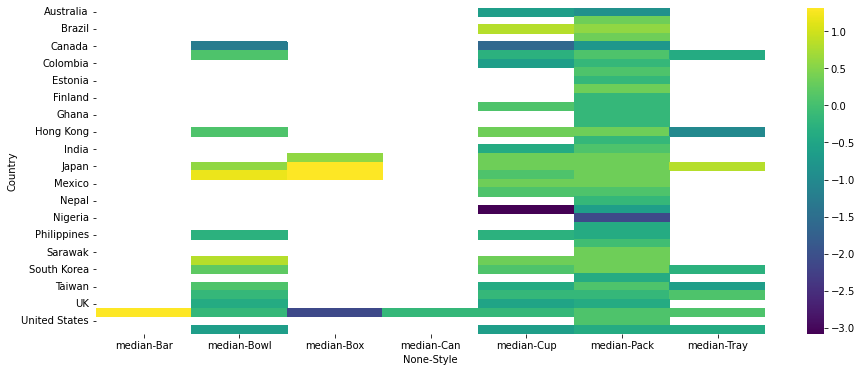

In [194]:
import seaborn as sns
from matplotlib import pyplot as plt
pivot = v.pivot_table(index=['Country'],values = 'Stars', columns = ['Style'], aggfunc = ['median'])
#print(pivot)
plt.figure(figsize=[15,6])
sns.heatmap(pivot, cmap='viridis')

# Verificando a semelhanda com k-means 
* pelas distancias normalizadas de Stars e Review

[0 4 0 ... 1 1 4]
KMeans(n_clusters=5)
['Stars', 'Review', 'Brand', 'Style', 'Country', 'StarsO', 'ReviewO', 'Cluster']
Cluster
0    743
1    386
2    459
3    847
4    141
Name: Country, dtype: int64


<Figure size 720x360 with 0 Axes>

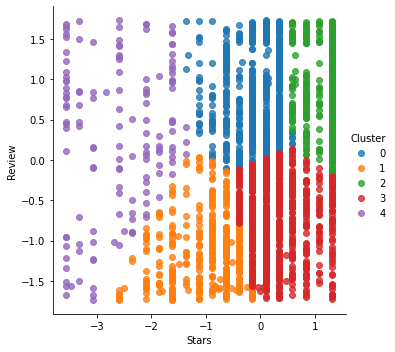

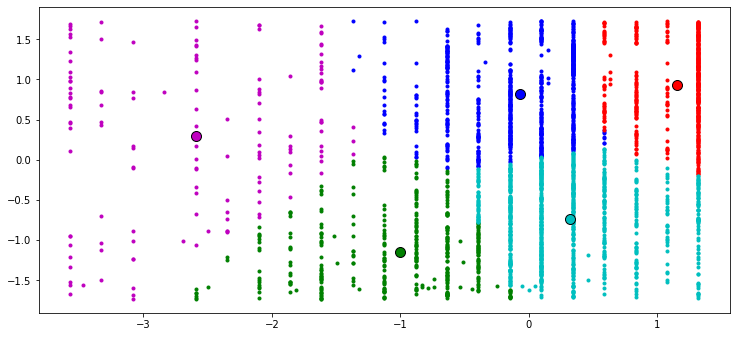

In [199]:
from sklearn.cluster import KMeans
nk = 5

km = KMeans(n_clusters=nk, random_state=None).fit(X=valoresNormalizados)
print(km.labels_)
print(km)

vN['Cluster'] = pd.DataFrame(km.labels_)
print(list(vN))
vN.head()
# quantos elementos por cluster
print(vN.groupby(['Cluster'])['Country'].count())

# #############################################################################
# Plot result
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
sns.lmplot(x = 'Stars', y = 'Review', data = vN, hue= 'Cluster', fit_reg=False)
fig = plt.figure(figsize=(10, 5))
fig.subplots_adjust(left=0.02, right=0.98, bottom=0.05, top=0.9)

# KMeans
k_means_labels = km.labels_
k_means_cluster_centers = km.cluster_centers_
X = valoresNormalizados

colors = cycle("bgrcmykbgrcmykbgrcmykbgrcmyk")
for k, col in zip(range(nk), colors):
    my_members = k_means_labels == k
    cluster_center = k_means_cluster_centers[k]
    plt.plot(X[my_members, 0], X[my_members, 1], col + ".")
    plt.plot(
        cluster_center[0],
        cluster_center[1],
        "o",
        markerfacecolor=col,
        markeredgecolor="k",
        markersize=10,
    )